# AE

In [1]:
from keras.models import Sequential 
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
from keras import backend as k
from keras.layers import Lambda
from tensorflow.keras.metrics import binary_crossentropy
import keras

from tensorflow.keras.datasets import mnist

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('Data.csv')

X = data.drop(['label','Label'], axis = 1)
y = data['label']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [4]:
# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_test = X_test.astype('float32') / 255.
X_test = X_test.values.reshape(-1,28,28,1)

In [5]:
# This is the dimension of the latent space (encoding space)
latent_dim = 2

 
data_shape = (X_train.shape[1], X_train.shape[2])

encoder = Sequential([
    tf.keras.layers.Flatten(input_shape=data_shape),
    Dense(192, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(latent_dim, name='encoder_output')
])

decoder = Sequential([
    Dense(64, activation='relu', input_shape=(latent_dim,)),
    Dense(128, activation='relu'),
    Dense(data_shape[0] * data_shape[1], activation='relu'),
    tf.keras.layers.Reshape(data_shape)
])

In [6]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

In [7]:
model_history = autoencoder.fit(X_train, X_train, epochs=8, batch_size=32, verbose=0)

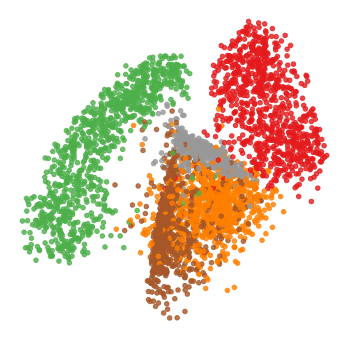

In [8]:
X_te_latent = encoder.predict(X_test, batch_size=256)
plt.figure(figsize=(6, 6))
plt.scatter(X_te_latent[:, 0],  X_te_latent[:, 1], s=20, alpha=0.8, cmap='Set1', c=y_test[0:X_test.shape[0]])
plt.axis('off')
plt.show()

# VAE

In [9]:
data = pd.read_csv('Data.csv')

X = data.drop(['label','Label'], axis = 1)
y = data['label']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [11]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.values.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.values.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_test.shape)

(17132, 784)
(4284, 784)


In [12]:
batch_size, n_epoch = 100, 150
latent_dim = 2

input_data = Input(shape=(X_train[0].shape))
X = Dense(200, activation='relu')(input_data)
X= Dense(100, activation='relu')(X)
X = Dense(30, activation='relu')(X)

mu = Dense(latent_dim)(X)
log_var = Dense(latent_dim)(X)

encoder = Model(input_data, mu, name='Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 200)               157000    
                                                                 
 dense_7 (Dense)             (None, 100)               20100     
                                                                 
 dense_8 (Dense)             (None, 30)                3030      
                                                                 
 dense_9 (Dense)             (None, 2)                 62        
                                                                 
Total params: 180,192
Trainable params: 180,192
Non-trainable params: 0
_________________________________________________________________


In [13]:
def sampling(args):
    mu, log_var = args
    eps = k.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return mu + k.exp(log_var) * eps

z = Lambda(sampling, output_shape=(latent_dim,))([mu, log_var])

In [14]:
z_decoder1 = Dense(30, activation='relu')
z_decoder2 = Dense(100, activation='relu')
z_decoder3 = Dense(200, activation='relu')
y_decoder = Dense((X_train[0].shape[0]), activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
z_decoded = z_decoder3(z_decoded)
y = y_decoder(z_decoded)

In [15]:
reconstruction_loss = binary_crossentropy(input_data, y) * X_train[0].shape
kl_loss = 0.5 * k.sum(k.square(mu) + k.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

vae = Model(input_data, y)
vae.add_loss(vae_loss)

vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 200)          157000      ['input_1[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 100)          20100       ['dense_6[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 30)           3030        ['dense_7[0][0]']                
                                                                                            

In [16]:
P = X_train[:17000,]

In [17]:
vae.compile(optimizer='rmsprop')
history = vae.fit(P, shuffle=True, epochs=14, batch_size=batch_size, validation_data=(P, None), verbose=1)

Epoch 1/14
170/170 [==============================] - 2s 9ms/step - loss: 209.9863 - val_loss: 178.9163
Epoch 2/14
170/170 [==============================] - 1s 8ms/step - loss: 172.4511 - val_loss: 166.8831
Epoch 3/14
170/170 [==============================] - 2s 9ms/step - loss: 164.6382 - val_loss: 161.2923
Epoch 4/14
170/170 [==============================] - 1s 8ms/step - loss: 157.1340 - val_loss: 154.1442
Epoch 5/14
170/170 [==============================] - 1s 8ms/step - loss: 152.8800 - val_loss: 150.9576
Epoch 6/14
170/170 [==============================] - 1s 8ms/step - loss: 149.6962 - val_loss: 147.5194
Epoch 7/14
170/170 [==============================] - 1s 8ms/step - loss: 147.0597 - val_loss: 145.1168
Epoch 8/14
170/170 [==============================] - 1s 8ms/step - loss: 144.9524 - val_loss: 143.4256
Epoch 9/14
170/170 [==============================] - 1s 8ms/step - loss: 143.1913 - val_loss: 141.6167
Epoch 10/14
170/170 [==============================] - 1s 8ms/st

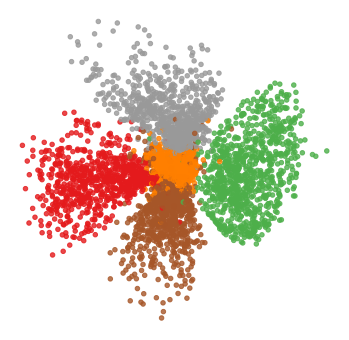

In [18]:
x_te_latent = encoder.predict(X_test, batch_size=256)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], s=20, alpha=0.8, cmap='Set1', c=y_test[0:X_test.shape[0]])
plt.axis('off')
plt.show()